Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
I0000 00:00:1735370334.467205      92 service.cc:145] XLA service 0x7ec0bc0159c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735370334.467278      92 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1735370334.467284      92 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/375 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.3906 - loss: 1.1128   

I0000 00:00:1735370349.440770      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 194s 469ms/step - accuracy: 0.7717 - loss: 0.5298 - val_accuracy: 0.3320 - val_loss: 8.5865 - learning_rate: 0.0010
Epoch 2/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8858 - loss: 0.2787 - val_accuracy: 0.3917 - val_loss: 2.2681 - learning_rate: 0.0010
Epoch 3/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 60ms/step - accuracy: 0.8995 - loss: 0.2468 - val_accuracy: 0.8240 - val_loss: 0.3611 - learning_rate: 0.0010
Epoch 4/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9075 - loss: 0.2298 - val_accuracy: 0.3320 - val_loss: 7.6598 - learning_rate: 0.0010
Epoch 5/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9138 - loss: 0.2184 - val_accuracy: 0.9273 - val_loss: 0.1708 - learning_rate: 0.0010
Epoch 6/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.9168 - loss: 0.2091 - val_accuracy: 0.8757 - val_loss: 0.2778 - learning_rate: 0.0010
Epoch 7/30
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9227 - loss: 0.19

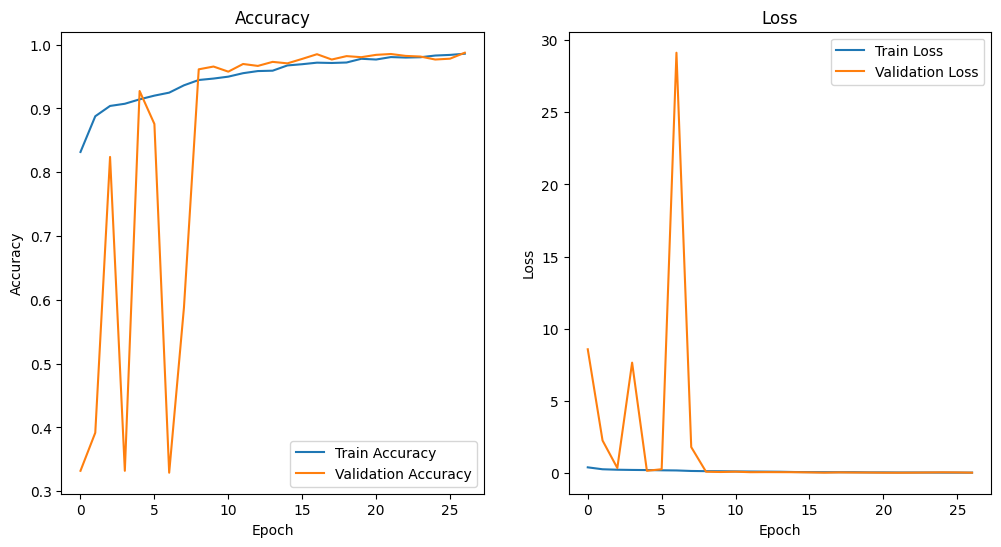

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,761,995 (6.72 MB)

 Trainable params: 587,011 (2.24 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 1,174,024 (4.48 MB)

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    Rescaling,
    GlobalAveragePooling2D,
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

# Paths and parameters
dataset_path = "/kaggle/input/lung-cancer-histopathological-images"  # Kaggle dataset path
batch_size = 32
img_size = (224, 224)

# Data augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal_and_vertical"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ]
)

# Load training and validation datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

# Apply normalization and augmentation
train_ds = train_ds.map(lambda x, y: (data_augmentation(x) / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))

# Optimize data pipeline
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Model architecture
model = Sequential([
    Rescaling(1.0 / 255, input_shape=(224, 224, 3)),  # Rescaling input
    Conv2D(32, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(256, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),

    GlobalAveragePooling2D(),  # Reduces parameters while retaining features

    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax"),  # 3 classes for classification
])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
]

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
)

# Save the final model
model.save("lung_cancer_model_final.h5")
print("Model saved as lung_cancer_model_final.h5")

# Plot training and validation metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

# Print the model summary
model.summary()

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step


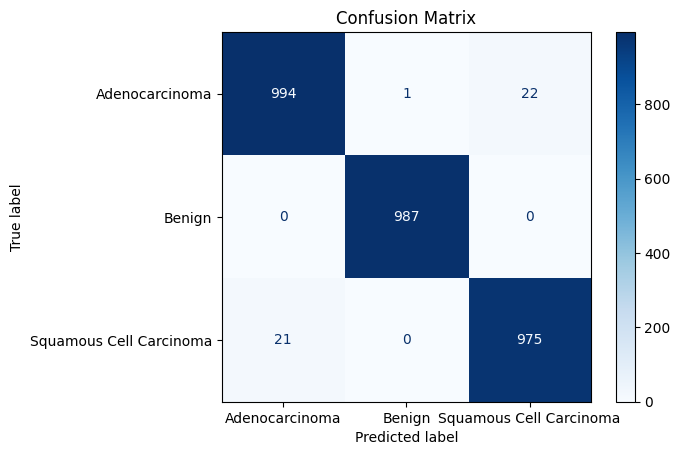

In [2]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the test dataset (assumes a similar structure as train/validation datasets)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",  # Use validation split for test evaluation
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

# Preprocess the test dataset
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Make predictions on the test dataset
true_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions = model.predict(test_ds)
predicted_labels = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Adenocarcinoma", "Benign", "Squamous Cell Carcinoma"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
